# Flower Species Image Classifier

This project implements a deep learning image classifier to recognize 102 different species of flowers using the [Oxford 102 Flower Dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html). The trained model can identify flower species from images, similar to what you might find in plant identification mobile applications.

<img src='assets/Flowers.png' width=500px>

## Import Resources

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from PIL import Image

print("TensorFlow:", tf.__version__)
print("TFDS:", tfds.__version__)

2026-01-16 18:19:16.134579: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-16 18:19:16.134637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-16 18:19:16.134694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TensorFlow: 2.14.0
TFDS: 4.9.4


## Load the Dataset

Use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.

In [2]:
tfds.disable_progress_bar()
(ds_train_raw, ds_valid_raw, ds_test_raw), ds_info = tfds.load(
    "oxford_flowers102",
    split=["train", "validation", "test"],
    as_supervised=True,      # returns (image, label)
    with_info=True
)

print("Loaded:", ds_info.name)
print("Splits:", list(ds_info.splits.keys()))

Dataset oxford_flowers102 downloaded and prepared to /home/student/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
Loaded: oxford_flowers102
Splits: [Split('train'), Split('test'), Split('validation')]


## Explore the Dataset

In [3]:
num_train = ds_info.splits["train"].num_examples
num_valid = ds_info.splits["validation"].num_examples
num_test  = ds_info.splits["test"].num_examples
num_classes = ds_info.features["label"].num_classes

print("Train examples:", num_train)
print("Validation examples:", num_valid)
print("Test examples:", num_test)
print("Number of classes:", num_classes)

Train examples: 1020
Validation examples: 1020
Test examples: 6149
Number of classes: 102


In [4]:
for i, (image, label) in enumerate(ds_train_raw.take(3), start=1):
    print(f"Image {i}: shape={image.numpy().shape}, label={label.numpy()}")

Image 1: shape=(500, 667, 3), label=72
Image 2: shape=(500, 666, 3), label=84
Image 3: shape=(670, 500, 3), label=70


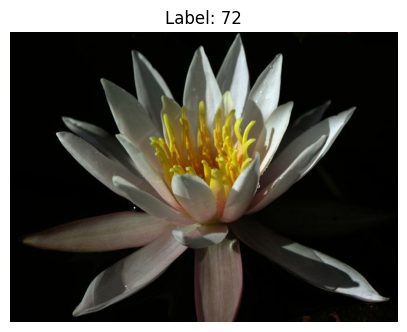

In [5]:
image, label = next(iter(ds_train_raw.take(1)))

plt.figure(figsize=(5, 5))
plt.imshow(image.numpy())
plt.title(f"Label: {label.numpy()}")
plt.axis("off")
plt.show()

### Label Mapping

load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give a dictionary mapping the integer coded labels to the actual names of the flowers.

In [6]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

# quick sanity check
print("Example mapping (first 5 keys):", list(class_names.keys())[:5])

Example mapping (first 5 keys): ['0', '1', '2', '3', '4']


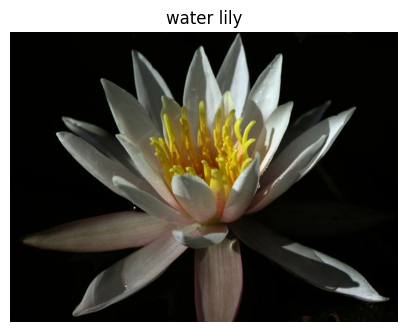

In [7]:
image, label = next(iter(ds_train_raw.take(1)))
label_int = int(label.numpy())
label_name = class_names.get(str(label_int), f"Unknown({label_int})")

plt.figure(figsize=(5, 5))
plt.imshow(image.numpy())
plt.title(label_name)
plt.axis("off")
plt.show()

## Create Pipeline

In [8]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def format_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)   # -> [0,1]
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image, label

train_ds = (
    ds_train_raw
    .map(format_image, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

valid_ds = (
    ds_valid_raw
    .map(format_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    ds_test_raw
    .map(format_image, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. We use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

In [9]:
FEATURE_EXTRACTOR_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5"

feature_extractor = hub.KerasLayer(
    FEATURE_EXTRACTOR_URL,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    trainable=False
)

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
    feature_extractor,
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=2,
    restore_best_weights=True
)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10,
    callbacks=[early_stop]
)

model.summary()

Epoch 1/10
32/32 [==============================] - 17s 193ms/step - loss: 4.3250 - accuracy: 0.0951 - val_loss: 3.4614 - val_accuracy: 0.3578
Epoch 2/10
32/32 [==============================] - 8s 156ms/step - loss: 2.5206 - accuracy: 0.4892 - val_loss: 2.0693 - val_accuracy: 0.5569
Epoch 3/10
32/32 [==============================] - 8s 153ms/step - loss: 1.3274 - accuracy: 0.7147 - val_loss: 1.4499 - val_accuracy: 0.6637
Epoch 4/10
32/32 [==============================] - 8s 156ms/step - loss: 0.7618 - accuracy: 0.8471 - val_loss: 1.2369 - val_accuracy: 0.6971
Epoch 5/10
32/32 [==============================] - 8s 152ms/step - loss: 0.4673 - accuracy: 0.9157 - val_loss: 1.0572 - val_accuracy: 0.7441
Epoch 6/10
32/32 [==============================] - 8s 157ms/step - loss: 0.3116 - accuracy: 0.9480 - val_loss: 0.9640 - val_accuracy: 0.7627
Epoch 7/10
32/32 [==============================] - 8s 150ms/step - loss: 0.2222 - accuracy: 0.9696 - val_loss: 0.9109 - val_accuracy: 0.7598
Epoch

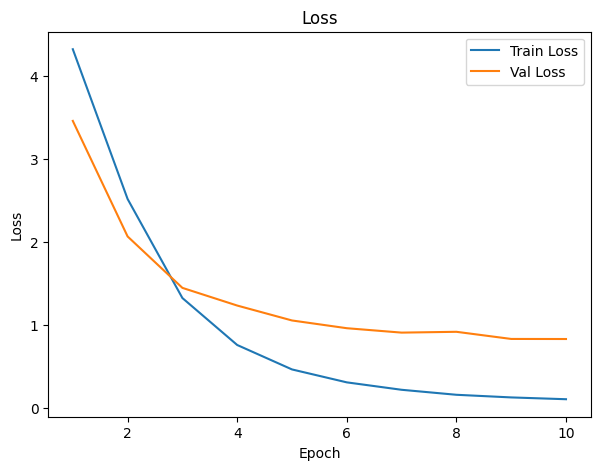

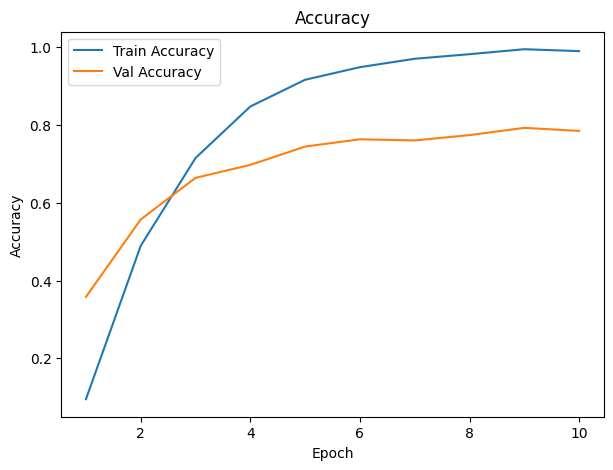

In [10]:
hist = history.history
epochs_ran = range(1, len(hist["loss"]) + 1)

plt.figure(figsize=(7, 5))
plt.plot(epochs_ran, hist["loss"], label="Train Loss")
plt.plot(epochs_ran, hist["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(7, 5))
plt.plot(epochs_ran, hist["accuracy"], label="Train Accuracy")
plt.plot(epochs_ran, hist["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.legend()
plt.show()

## Testing The Network

In [11]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

193/193 [==============================] - 21s 107ms/step - loss: 0.9785 - accuracy: 0.7549
Test Loss: 0.9784597158432007
Test Accuracy: 0.7549194693565369


## Save the Model

In the cell below we save the model as a Keras model (*i.e.* save it as an HDF5 file).

In [12]:
try:
    model.save("flower_classifier.h5")
    print("Saved model to flower_classifier.h5")
except Exception as e:
    print("Could not save to HDF5 (.h5). Reason:", e)
    model.save("flower_classifier.keras")
    print("Saved model to flower_classifier.keras instead")


/usr/local/lib/python3.11/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved model to flower_classifier.h5


## Load the Keras Model

Load the Keras model saved above.

In [13]:
loaded_model = None

try:
    loaded_model = tf.keras.models.load_model(
        "flower_classifier.h5",
        custom_objects={"KerasLayer": hub.KerasLayer}
    )
    print("Loaded model from flower_classifier.h5")
except Exception as e:
    print("Could not load .h5. Reason:", e)
    loaded_model = tf.keras.models.load_model(
        "flower_classifier.keras",
        custom_objects={"KerasLayer": hub.KerasLayer}
    )
    print("Loaded model from flower_classifier.keras")

loaded_model.summary()


Loaded model from flower_classifier.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 102)               26214     
                                                                 
Total params: 2612134 (9.96 MB)
Trainable params: 354150 (1.35 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


### Image Pre-processing

In [14]:
def process_image(image: np.ndarray) -> np.ndarray:
    """
    Convert a NumPy image array to a (224, 224, 3) float32 NumPy array in [0, 1].
    """
    image_tf = tf.convert_to_tensor(image)
    image_tf = tf.image.convert_image_dtype(image_tf, tf.float32)  # -> [0,1]
    image_tf = tf.image.resize(image_tf, (IMAGE_SIZE, IMAGE_SIZE))
    return image_tf.numpy()


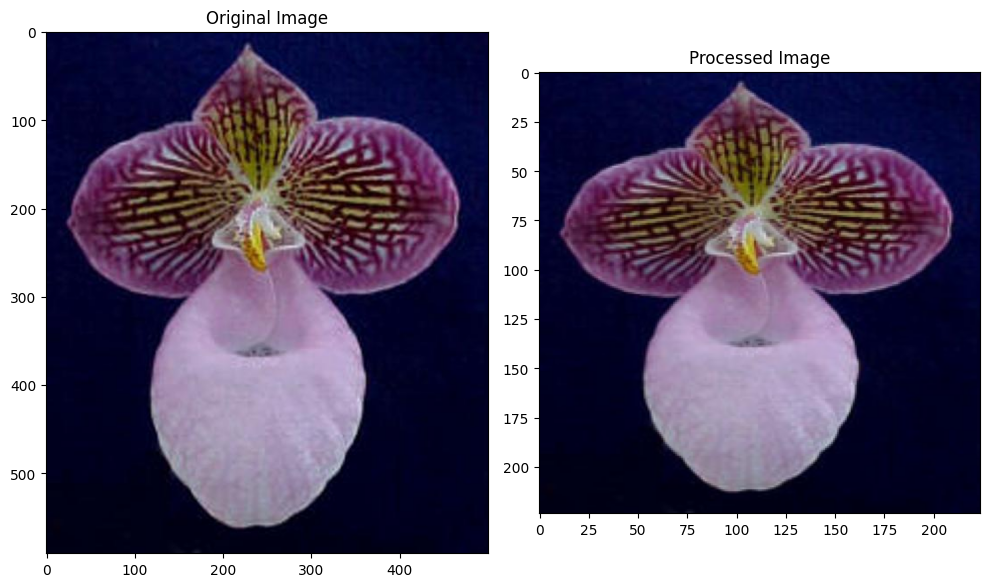

In [15]:
image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

### Inference

In [16]:
def predict(image_path: str, model: tf.keras.Model, top_k: int = 5):
    """
    Returns:
      probs: 1D NumPy array of top_k probabilities (descending)
      classes: list of top_k class labels as strings (matching label_map.json keys)
    """
    im = Image.open(image_path)
    image = np.asarray(im)

    processed = process_image(image)                 # (224,224,3)
    processed = np.expand_dims(processed, axis=0)    # (1,224,224,3)

    preds = model.predict(processed, verbose=0)[0]   # (num_classes,)
    topk = tf.nn.top_k(preds, k=top_k)

    probs = topk.values.numpy()
    classes = [str(int(i)) for i in topk.indices.numpy()]
    return probs, classes

# Sanity Check

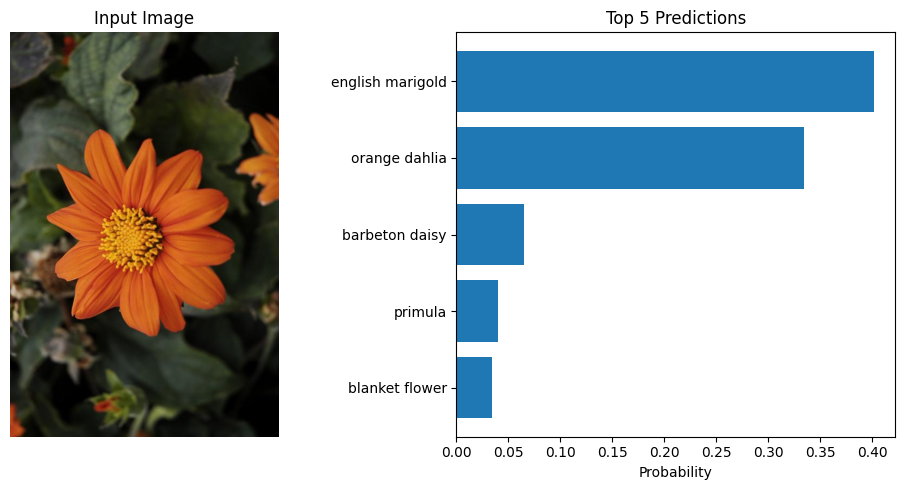

Top-5 probs: [0.4021304  0.3343801  0.06467306 0.04020984 0.03401897]
Top-5 classes: ['4', '58', '40', '52', '99']
Top-5 names: ['english marigold', 'orange dahlia', 'barbeton daisy', 'primula', 'blanket flower']


In [17]:
image_path = "./test_images/orange_dahlia.jpg"  # change to any test image
probs, classes = predict(image_path, loaded_model, top_k=5)

# Convert class ids -> names
names = [class_names.get(c, f"Unknown({c})") for c in classes]

# Load original image for display
im = Image.open(image_path)
img = np.asarray(im)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

ax1.imshow(img)
ax1.set_title("Input Image")
ax1.axis("off")

# Bar plot (top at top)
y_pos = np.arange(len(names))
ax2.barh(y_pos, probs)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(names)
ax2.invert_yaxis()
ax2.set_xlabel("Probability")
ax2.set_title("Top 5 Predictions")

plt.tight_layout()
plt.show()

print("Top-5 probs:", probs)
print("Top-5 classes:", classes)
print("Top-5 names:", names)